# Compressible Flow - Inviscid Bump

This notebook provides a Python approach to setup and run the standard tutorial case [Inviscid Bump](https://su2code.github.io/tutorials/Inviscid_Bump/) and reading that case before getting here is highly recommended, since we will not be discussing all the points.

The main goal is provide a full Python interface to the problem from case construction to post-processing. This is done through our package `majordome` and [`pyvista`](https://docs.pyvista.org/getting-started/index.html), an excellent tool for VTK data rendering. Alternative approaches of VTK data rendering are discussed [here](https://stackoverflow.com/questions/56401123).


In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import pyvista as pv

Next we configure `pv` to [display static images in notebook](https://docs.pyvista.org/user-guide/jupyter/index.html). We also start the display.

In [86]:
pv.set_jupyter_backend("static")

In [87]:
from majordome.su2.enums import *
from majordome.su2.groups import *

## Domain inspection

As of any CFD problem, visualization is of utmost importance. Using `pyvista` we provide below the rendering of problem mesh. Notice that names of *tags* are not supported by `meshio` package (actually reading the mesh under the hood as in this case it is not VTK).

In fact, that is quite useful for us cause we get to see names of these *markers* printed in warning messages: the system is composed of an inlet, a pair of upper and lower walls, and an outlet. From the `outline` property we can get a good guess of camera placement to see the mesh later.

In [88]:
grid = pv.read("mesh.su2")
grid.outline()

Warning: meshio does not support tags of string type.
    Surface tag  inlet will be replaced by 1

Warning: meshio does not support tags of string type.
    Surface tag  lower_wall will be replaced by 2

Warning: meshio does not support tags of string type.
    Surface tag  outlet will be replaced by 3

Warning: meshio does not support tags of string type.
    Surface tag  upper_wall will be replaced by 4

PolyData,Information
N Cells,12
N Points,8
N Strips,0
X Bounds,"0.000e+00, 3.000e+00"
Y Bounds,"0.000e+00, 1.000e+00"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


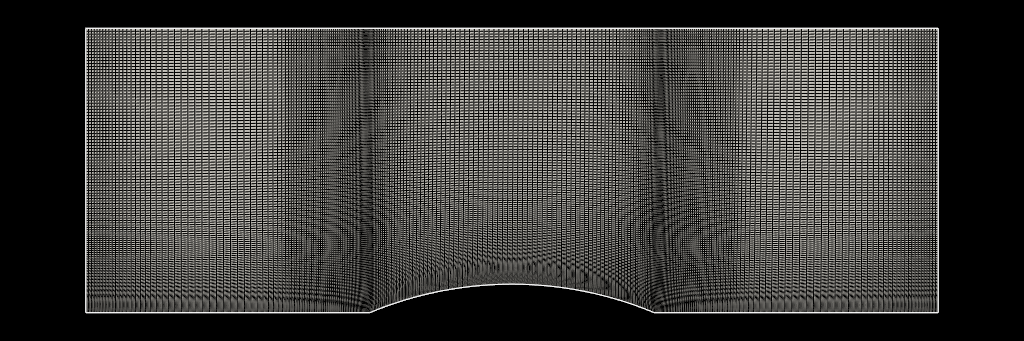

In [89]:
cpos = ((1.5, 0.5, 5.0),
        (1.5, 0.5, 0.0),
        (0.0, 0.0, 0.0))

p = pv.Plotter()
p.add_mesh(grid, show_edges=True, color="w")

p.set_background("k")
p.reset_camera()
p.camera.zoom("tight")
p.camera_position = cpos
p.camera.parallel_scale *= 1.2

p.show()

In `pyvista` a broad range of mesh operations are possible. As we have seen, tags were transformed in numbers, which are actually stored in `su2:tag` cell data in the case of SU2 meshes. Using method `remove_cells` we can filter each of these conditions.

With these selections in hand we can use a more complex feature of `pyvista` to make a composite plot depicting each of these selected tags. A grid is also added to the image to provide the size of the system, which will later also be need to analyse the data.

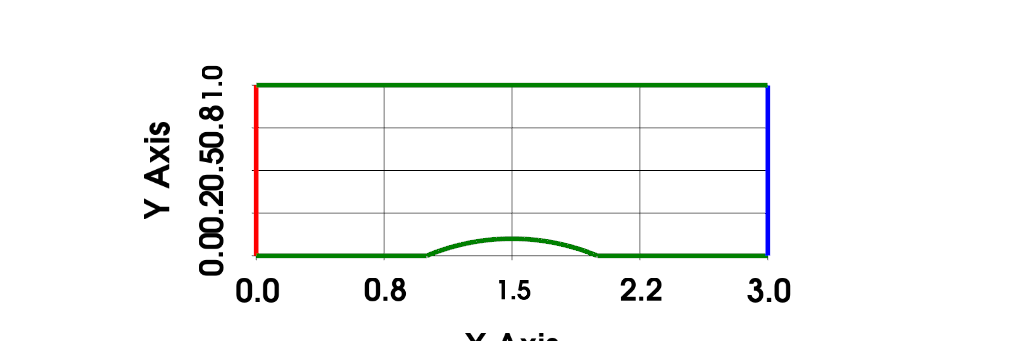

In [ ]:
all_tags = grid.cell_data["su2:tag"]
external = grid.copy().remove_cells(all_tags == 0)
all_tags = external.cell_data["su2:tag"]

tag_inlet      = external.copy().remove_cells(all_tags != 1)
tag_lower_wall = external.copy().remove_cells(all_tags != 2)
tag_outlet     = external.copy().remove_cells(all_tags != 3)
tag_upper_wall = external.copy().remove_cells(all_tags != 4)

p = pv.Plotter()
# p.add_mesh(grid.copy(), show_edges=True, color="w")
p.add_mesh(tag_inlet,      color="r", show_edges=True, line_width=5)
p.add_mesh(tag_lower_wall, color="g", show_edges=True, line_width=5)
p.add_mesh(tag_outlet,     color="b", show_edges=True, line_width=5)
p.add_mesh(tag_upper_wall, color="g", show_edges=True, line_width=5)

# p.add_axes()
# p.show(cpos=cpos)

p.show_grid(color="k")
# p.set_background(color="k")
p.reset_camera()
p.camera.zoom("tight")
p.camera_position = cpos
p.camera.parallel_scale *= 2

p.show()

## Prepare case configuration

In this section we show how to use `majordome` to transform the [original case](https://github.com/su2code/Tutorials/tree/master/compressible_flow/Inviscid_Bump) into a Python script. This has the advantage to allow parametric generation of cases and other computations to be performed directly in case construction. Different *sections* of SU2 configuration files are simply filled-in through Python classes as follows. Dumping of *.cfg* file is automatically manager by `SU2Configuration`.

In [91]:
conf = SU2Configuration(
    problem = ProblemDefinition(
        solver = SolverType.EULER,
    )
)

conf.compressible_freestream = CompressibleFreeStreamDefinition(
    mach             = 0.5,
    angle_of_attack  = 0.0,
    sideslip_angle   = 0.0,
    pressure         = 101325.0,
    temperature      = 288.0
)

conf.reference_values = ReferenceValues(
    ref_origin_moment_x = 0.25,
    ref_origin_moment_y = 0.00,
    ref_origin_moment_z = 0.00,
    ref_length          = 1.0,
    ref_area            = 1.0
)

conf.boundary_conditions = BoundaryConditions(
    marker_euler  = ["upper_wall", "lower_wall"],
    marker_inlet  = ["inlet", 288.6, 102010.0, 1.0, 0.0, 0.0],
    marker_outlet = ["outlet", 101300.0],
    inlet_type    = InletType.TOTAL_CONDITIONS,
)

conf.surfaces_identification = SurfacesIdentification(
    marker_plotting   = ["lower_wall"],
    marker_monitoring = ["upper_wall", "lower_wall"],
)

conf.common_numerical_parameters = CommonParametersNumerical(
    num_method_grad = NumMethodGrad.GREEN_GAUSS,
    cfl_number      = 50.0,
    cfl_adapt       = YesNoEnum.YES,
    cfl_adapt_param = ParametersCFL(
        factor_down            = 0.1,
        factor_up              = 2.0,
        min_value              = 50.0,
        max_value              = 1.0e+10
    ),
    rk_alpha_coeff = (0.66667, 0.66667, 1.000000),
)

conf.linear_solver_parameters = LinearSolverParameters(
    linear_solver      = LinearSolver.FGMRES,
    linear_solver_prec = Preconditioner.ILU,
    error              = 1.0e-10,
    n_iter             = 20
)

conf.multigrid_parameters = MultigridParameters(
    mg_level             = 3,
    mg_cycle             = MgCycle.W_CYCLE,
    mg_pre_smooth        = [1, 2, 3, 3],
    mg_post_smooth       = [0, 0, 0, 0],
    mg_correction_smooth = [0, 0, 0, 0],
    mg_damp_restriction  = 1.0,
    mg_damp_prolongation = 1.0

)

conf.flow_numerical_method = FlowNumericalMethod(
    conv_num_method_flow = ConvectiveScheme.JST,
    time_discre_flow     = TimeDiscretization.EULER_IMPLICIT,
)

conf.slope_limiter = SlopeLimiter(
    jst_sensor_coeff = (0.5, 0.02)
)

conf.solver_control = SolverControl(
    iter                 = 999999,
    conv_field           = "RMS_DENSITY",
    conv_residual_minval = -10,
    conv_startiter       = 10,
    conv_cauchy_elems    = 100,
    conv_cauchy_eps      = 1.0e-10,
)

conf.screen_history_info = ScreenHistoryInfo(
    screen_output = [
        "INNER_ITER",
        "WALL_TIME",
        "RMS_DENSITY",
        "RMS_ENERGY",
        "LIFT",
        "DRAG"
    ],
)

conf.io_file_info = IOFileInfo(
    mesh_filename         = "mesh.su2",
    mesh_format           = MeshFormat.SU2,
    mesh_out_filename     = "mesh_out.su2",
    solution_filename     = "solution_flow",
    solution_adj_filename = "solution_adj",
    tabular_format        = TabularFormat.CSV,
    conv_filename         = "history.dat",
    restart_filename      = "restart_flow",
    restart_adj_filename  = "restart_adj",
    volume_filename       = "flow",
    volume_adj_filename   = "adjoint",
    grad_objfunc_filename = "of_grad.dat",
    surface_filename      = "surface_flow",
    surface_adj_filename  = "surface_adjoint",
)

conf.to_file("model.cfg", force=True)

Before going to the next section, let's make a dry run for verification of configuration file:

In [97]:
!SU2_CFD -d model.cfg


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 8.3.0 "Harrier"                           |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2025, SU2 Contributors                                 |
|                                    

## Run simulation

In [92]:
# !SU2_CFD model.cfg

## Post-processing